In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

In [ ]:
#Steps to get data

#Get the dataframe
#Add the label column
#Put the dataframe into tensors
#Pad all the images to be the same size

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
ROOT = '.data'

train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True)

mean = train_data.data.float().mean() / 255
std = train_data.data.float().std() / 255

print(f'Calculated mean: {mean}')
print(f'Calculated std: {std}')

Calculated mean: 0.13066047430038452
Calculated std: 0.30810779333114624


In [72]:
import re
import ast
import numpy as np
def str2array(s):
    #source:https://stackoverflow.com/questions/35612235/how-to-read-numpy-2d-array-from-string/44323021#44323021
    # Remove space after [
    s=re.sub('\[ +', '[', s.strip())
    # Replace commas and spaces
    s=re.sub('[,\s]+', ', ', s)
    return np.array(ast.literal_eval(s))

In [81]:
import pandas as pd
df_821_path = r'C:\Users\rz200\Documents\Development\cell-SCT\classification\imported_CSV\dataframe_821'
df = pd.read_csv(df_821_path)

In [84]:
conditions = [
    (df['S_Phase'] == True),
    (df['G1_Phase'] == True),
    (df['G2_M_Phase'] == True),
    (df['S_Phase'] == False) & (df['G1_Phase'] == False) & (df['G2_M_Phase'] == False)
]
values = [0, 1, 2, 3]
df['label'] = np.select(conditions, values)

In [102]:
df['label'].value_counts()

1    60922
0    49335
2    17614
3    12163
Name: label, dtype: int64

In [86]:
n = 65
img_shape = str2array(df['pcna_crops'][n]).shape
pcna_val = df['pcna_values'][n]
label = df['label'][n]
#landmarks = np.asarray(landmarks)
#landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image shape: {}'.format(img_shape))
print('Image PCNA val: {}'.format(pcna_val))
print('Image label: {}'.format(label))

Image shape: (22, 22)
Image PCNA val: 0.208056982109437
Image label: 1


In [150]:
df = pd.read_csv(df_821_path)[:100]

In [153]:
df_821_short_path = r'C:\Users\rz200\Documents\Development\cell-SCT\classification\imported_CSV\dataframe_821_short'

df = pd.read_csv(df_821_short_path)

In [89]:
from torch.utils.data import Dataset, DataLoader
import os

def str2array(s):
    #source:https://stackoverflow.com/questions/35612235/how-to-read-numpy-2d-array-from-string/44323021#44323021
    # Remove space after [
    s=re.sub('\[ +', '[', s.strip())
    # Replace commas and spaces
    s=re.sub('[,\s]+', ', ', s)
    return np.array(ast.literal_eval(s))


class CCCDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.cell_dataframe = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.cell_dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = str2array(self.cell_dataframe['pcna_crops'][idx])
        label = df['label'][idx]
        sample = {'image': image, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [147]:
import numbers

def get_padding(image):
    w, h = image['image'].shape
    max_wh = np.max([w, h])
    h_padding = (max_wh - w) / 2
    v_padding = (max_wh - h) / 2
    l_pad = h_padding if h_padding % 1 == 0 else h_padding+0.5
    t_pad = v_padding if v_padding % 1 == 0 else v_padding+0.5
    r_pad = h_padding if h_padding % 1 == 0 else h_padding-0.5
    b_pad = v_padding if v_padding % 1 == 0 else v_padding-0.5
    padding = (int(l_pad), int(t_pad), int(r_pad), int(b_pad))
    return padding

class NewPad(object):
    def __init__(self, fill=0, padding_mode='constant'):
        assert isinstance(fill, (numbers.Number, str, tuple))
        assert padding_mode in ['constant', 'edge', 'reflect', 'symmetric']

        self.fill = fill
        self.padding_mode = padding_mode

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to be padded.

        Returns:
            PIL Image: Padded image.
        """
        img = img['image']
        print(img)
        return F.pad(img, get_padding(img), self.fill, self.padding_mode)

    def __repr__(self):
        return self.__class__.__name__ + '(padding={0}, fill={1}, padding_mode={2})'.format(self.fill, self.padding_mode)

In [157]:
df = pd.read_csv(df_821_short_path)
df['label'] = np.select(conditions, values)

ValueError: Length of values (140034) does not match length of index (100)

In [154]:
train_data = CCCDataset(csv_file=df_821_short_path, transform=data_transforms['train'])


In [155]:

print(train_data.__getitem__(0))

KeyError: 'label'

In [126]:
pcna_dataset = CCCDataset(csv_file=df_821_path)

In [132]:
print(pcna_dataset[0])

{'image': array([[0.0822789 , 0.08341402, 0.08655227, 0.09047508, 0.08997429,
        0.08643542, 0.09054185, 0.08840517, 0.09137649, 0.09162688,
        0.08895603, 0.09331286, 0.09434781, 0.09219444, 0.08620172,
        0.09409742, 0.09379695, 0.09396388, 0.09099256, 0.08752045,
        0.08848863, 0.08982406],
       [0.08648549, 0.08852202, 0.0890395 , 0.0915935 , 0.08992421,
        0.08770407, 0.08641872, 0.08775415, 0.09247822, 0.09603379,
        0.09523253, 0.09690181, 0.10130872, 0.09751945, 0.09665142,
        0.09870464, 0.09216105, 0.08967382, 0.09012453, 0.08581778,
        0.09259507, 0.08451574],
       [0.0918272 , 0.08498314, 0.09663473, 0.09090909, 0.08471606,
        0.09429773, 0.0887891 , 0.09463159, 0.09658465, 0.09503222,
        0.11022268, 0.12756652, 0.12521283, 0.13432711, 0.12542984,
        0.1166995 , 0.10077455, 0.0973859 , 0.09277869, 0.09990652,
        0.08628518, 0.08977398],
       [0.09219444, 0.09072547, 0.09156011, 0.08892265, 0.085534  ,
       

0 (22, 22) 1
1 (22, 22) 1
2 (22, 22) 1
3 (22, 22) 1
4 (22, 22) 1
5 (18, 18) 1
6 (24, 24) 1
7 (24, 24) 1
8 (20, 20) 1
9 (22, 22) 1
10 (22, 22) 1
11 (20, 20) 1
12 (22, 22) 1
13 (26, 26) 1
14 (24, 24) 1
15 (22, 22) 1
16 (24, 24) 1
17 (22, 22) 1
18 (22, 22) 1
19 (24, 24) 1


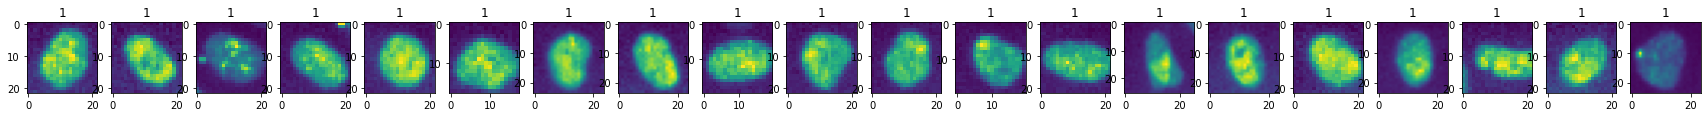

In [127]:
plt.figure(figsize=(30,30))
for i in range(20):
    sample = pcna_dataset[i]
    print(i, sample['image'].shape, sample['label'])
    plt.subplot(1,20,i+1)
    plt.imshow(sample['image'])
    plt.title(sample['label'])
plt.show()

In [128]:
data_transforms = {
    'train': transforms.Compose([
        NewPad(),
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        NewPad(),
        transforms.Resize((224,224)),
        transforms.ToTensor(),
    ]),
}

In [135]:
train_data = CCCDataset(csv_file=df_821_path,transform=data_transforms['train'])

In [137]:
print(train_data.__getitem__(0))

AttributeError: 'dict' object has no attribute 'shape'

In [106]:

train_transforms = transforms.Compose([
    transforms.RandomRotation(5, fill=(0,)),
    #transforms.RandomCrop(28, padding=2),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[mean], std=[std])
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=[mean], std=[std])
])

In [107]:

train_data = CCCDataset(csv_file=df_821_path,transform=train_transforms)

In [110]:
print(train_data)

TypeError: Unexpected type <class 'dict'>

In [6]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])

In [7]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [8]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 54000
Number of validation examples: 6000
Number of testing examples: 10000


In [9]:
BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

In [10]:
class LeNet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=6,
                               kernel_size=5)

        self.conv2 = nn.Conv2d(in_channels=6,
                               out_channels=16,
                               kernel_size=5)

        self.fc_1 = nn.Linear(16 * 4 * 4, 120)
        self.fc_2 = nn.Linear(120, 84)
        self.fc_3 = nn.Linear(84, output_dim)

    def forward(self, x):

        # x = [batch size, 1, 28, 28]

        x = self.conv1(x)

        # x = [batch size, 6, 24, 24]

        x = F.max_pool2d(x, kernel_size=2)

        # x = [batch size, 6, 12, 12]

        x = F.relu(x)

        x = self.conv2(x)

        # x = [batch size, 16, 8, 8]

        x = F.max_pool2d(x, kernel_size=2)

        # x = [batch size, 16, 4, 4]

        x = F.relu(x)

        x = x.view(x.shape[0], -1)

        # x = [batch size, 16*4*4 = 256]

        h = x

        x = self.fc_1(x)

        # x = [batch size, 120]

        x = F.relu(x)

        x = self.fc_2(x)

        # x = batch size, 84]

        x = F.relu(x)

        x = self.fc_3(x)

        # x = [batch size, output dim]

        return x, h

In [11]:
OUTPUT_DIM = 10

model = LeNet(OUTPUT_DIM)

In [12]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 44,426 trainable parameters


In [13]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

In [14]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [15]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [16]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [18]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [19]:
EPOCHS = 3

best_valid_loss = float('inf')
print('yy')
for epoch in range(EPOCHS):
    print('xx')

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')

yy
xx


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

xx


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

xx


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 20s
	Train Loss: 0.085 | Train Acc: 97.35%


In [ ]:
model.load_state_dict(torch.load('tut2-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')